In [1]:
#!pip install janome

import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from torch import nn, Tensor
import torch.nn.functional as F
#from torchtext.vocab import vocab
#import torchtext.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms
import numpy as np
import math
import janome
from janome.tokenizer import Tokenizer
#import spacy
from collections import Counter
from torch.utils.data.sampler import SubsetRandomSampler
import time
#from torchtext.vocab import build_vocab_from_iterator
import levenshtein
import json
import pickle
from timm.scheduler import CosineLRScheduler
import nltk
from nltk import bleu_score

In [2]:
token_list_path = "20240531_ntt_idx_to_wakati_auto.json"
with open( token_list_path, mode="r" , encoding="utf-8" ) as f:
    token_list = json.load( f )

token_list_en_path = "20240531_ntt_idx_to_word_auto.json"
with open( token_list_en_path, mode="r" , encoding="utf-8" ) as f:
    token_list_en = json.load( f )

idx_list_path = "20240531_ntt_wakati_to_idx_auto.json"
with open( idx_list_path, mode="r" , encoding="utf-8" ) as f:
    idx_list = json.load( f )

idx_list_en_path = "20240531_ntt_word_to_idx_auto.json"
with open( idx_list_en_path, mode="r" , encoding="utf-8" ) as f:
    idx_list_en = json.load( f )
    
enc_vocab_size, dec_vocab_size = len(token_list) - 1, len(token_list_en) - 1
print(enc_vocab_size, dec_vocab_size)

184855 181271


In [3]:
a = torch.tensor([ 0,1,2,3,4,5,6 ])

#n = 0

#ii = [ i for i in a ]

#print( ii )

b = [ token_list[str(i.item())] for i in a ]

print( b )


d = idx_list['<pad>']

print( d )

['<pad>', '<bos>', '<eos>', '<unk>', '鼻', '・', '口']
0


In [4]:
# -*- coding: utf-8 -*-

#
# Pytorchで用いるDatasetの定義
#

# PytorchのDatasetモジュールをインポート
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

# 数値演算用モジュール(numpy)をインポート
import numpy as np

# sysモジュールをインポート
import sys


class SequenceDataset(Dataset):
    ''' ミニバッチデータを作成するクラス
        torch.utils.data.Datasetクラスを継承し，
        以下の関数を定義する
        __len__: 総サンプル数を出力する関数
        __getitem__: 1サンプルのデータを出力する関数
    feat_scp:  特徴量リストファイル
    label_scp: ラベルファイル
    feat_mean: 特徴量の平均値ベクトル
    feat_std:  特徴量の次元毎の標準偏差を並べたベクトル 
    pad_index: バッチ化の際にフレーム数を合わせる
               ためにpaddingする整数値
    splice:    前後(splice)フレームを特徴量を結合する
               splice=1とすると，前後1フレーム分結合
               するので次元数は3倍になる．
               splice=0の場合は何もしない
    '''
    def __init__(self, 
                 filename,
                 pad_index_j=5,
                 pad_index_e=5,
                 ):

        # 特徴量リスト，ラベルを1行ずつ
        # 読み込みながら情報を取得する
        self.pad_index_j = pad_index_j
        self.pad_index_e = pad_index_e
        #self.ens = []
        self.en_list = []
        self.en_lens = []
        #self.jps = []
        self.jp_list = []
        self.jp_lens = []
        self.num_data = 0
        with open(filename, mode='r', encoding="utf-8") as file_f:
            for line in file_f:
                line = line.replace( "\n", "" )
                # 各行をスペースで区切り，
                # リスト型の変数にする
                #print( "line:", line)
                en = line.split("\t")[1]
                #self.ens.append( en )
                #self.ens = self.ens
                en1 = en.split( ' ' )
                self.en_list.append( en1 )
                self.en_lens.append( len( en1 ) )

                jp = line.split("\t")[0]
                #self.jps.append( jp )
                #self.jps = self.jps
                jp1 = jp.split( ' ' )
                self.jp_list.append( jp1 )
                self.jp_lens.append( len( jp1 ) )
                self.num_data += 1

        self.en_lens = np.int64( np.array( self.en_lens ) )
        self.jp_lens = np.int64( np.array( self.jp_lens ) )


        # フレーム数の最大値を得る
        self.max_en_len = np.max(self.en_lens)
        # ラベル長の最大値を得る
        self.max_jp_len = np.max(self.jp_lens)

        # ラベルデータの長さを最大フレーム長に
        # 合わせるため，pad_indexの値で埋める
        for n in range(self.num_data):
            print( "n:", n )
            # 埋めるフレームの数
            # = 最大フレーム数 - 自分のフレーム数
            pad_len = self.max_en_len \
                    - self.en_lens[n]
            # pad_indexの値で埋める
            #print("n:{}".format( n ) )
            #print("len of en_list:{}".format( len( self.en_list ) ) )
            tmp = self.en_list[n]
            self.en_list[n] = np.pad( tmp, (0, pad_len), mode='constant', constant_values=(self.pad_index_e, self.pad_index_e ))
            #print( self.en_list[n][0].dtype )
            #tmp = torch.tensor( self.en_list[n] )
            #tmp = F.pad( tmp, (0, pad_len), 'constant', self.pad_index_e )
            #self.en_list[n] = tmp.to('cpu').detach().numpy().copy()
            #print( self.en_list[n] )
            #tmp = torch.tensor( self.en_list[n] )
            #if torch.any( tmp == 5785 ):
            #    print( "tmp == 5785" )
            pad_len = self.max_jp_len \
                    - self.jp_lens[n]
            # pad_indexの値で埋める
            #print("n:{}".format( n ) )
            #print("len of en_list:{}".format( len( self.en_list ) ) )
            self.jp_list[n] = np.pad(self.jp_list[n],[0, pad_len],mode='constant', constant_values=self.pad_index_j)

        self.en_list = np.int64( np.array( self.en_list ) )
        self.jp_list = np.int64( np.array( self.jp_list ) )
        #print( self.jp_list )

        #max = np.max( self.jp_list, axis =1 )
        #maxmax = np.max( max )
        #print( "maxmax:{}".format(maxmax) )


    def __len__(self):
        ''' 学習データの総サンプル数を返す関数
        本実装では発話単位でバッチを作成するため，
        総サンプル数=発話数である．
        '''
        return self.num_data


    def __getitem__(self, idx):
        ''' サンプルデータを返す関数
        本実装では発話単位でバッチを作成するため，
        idx=発話番号である．
        '''
        # 特徴量系列のフレーム数
        jp_len = self.jp_lens[idx]
        # ラベルの長さ
        en_len = self.en_lens[idx]

        # ラベル
        jp = self.jp_list[idx]
        #print( jp )
        #jp = np.fromfile(self.jp_list[idx],dtype=np.int64)

        # 発話ID
        en = self.en_list[idx]
        #ens = np.fromfile(self.en_list[idx],dtype=np.float32)

        #batch = {}
        #batch['jp'] = jp
        #batch['en'] = en
        #batch['jp_len'] = jp_len
        #batch['en_len'] = en_len


        # 特徴量，ラベル，フレーム数，
        # ラベル長，発話IDを返す
        #return (jps, jp_lens, ens,  en_lens)
        return (jp, en, jp_len, en_len )

In [5]:
BATCH_SIZE = 20
batch_size = BATCH_SIZE

#train_dataset = SequenceDataset( "20240531_ntt_ids_train_auto.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>'] )
train_dataset = SequenceDataset( "20240531_ntt_ids_dev_auto.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>'] )
val_dataset = SequenceDataset( "20240531_ntt_ids_dev_auto.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>']  )
    
# 訓練データのDataLoaderを呼び出す
# 訓練データはシャッフルして用いる
#  (num_workerは大きい程処理が速くなりますが，
#   PCに負担が出ます．PCのスペックに応じて
#   設定してください)

num_workers = 4 if torch.cuda.is_available() else 0

train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers)
# 開発データのDataLoaderを呼び出す
# 開発データはデータはシャッフルしない
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

print( len( train_loader ))
print( len( val_loader ))


text, target, text_len, target_len = next(iter(train_loader))
print(text[0], target[0], text_len[0],target_len[0], sep="\n")

n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 2302
n: 2303
n: 2304
n: 2305
n: 2306
n: 2307
n: 2308
n: 2309
n: 2310
n: 2311
n: 2312
n: 2313
n: 2314
n: 2315
n: 2316
n: 2317
n: 2318
n: 2319
n: 2320
n: 2321
n: 2322
n: 2323
n: 2324
n: 2325
n: 2326
n: 2327
n: 2328
n: 2329
n: 2330
n: 2331
n: 2332
n: 2333
n: 2334
n: 2335
n: 2336
n: 2337
n: 2338
n: 2339
n: 2340
n: 2341
n: 2342
n: 2343
n: 2344
n: 2345
n: 2346
n: 2347
n: 2348
n: 2349
n: 2350
n: 2351
n: 2352
n: 2353
n: 2354
n: 2355
n: 2356
n: 2357
n: 2358
n: 2359
n: 2360
n: 2361
n: 2362
n: 2363
n: 2364
n: 2365
n: 2366
n: 2367
n: 2368
n: 2369
n: 2370
n: 2371
n: 2372
n: 2373
n: 2374
n: 2375
n: 2376
n: 2377
n: 2378
n: 2379
n: 2380
n: 2381
n: 2382
n: 2383
n: 2384
n: 2385
n: 2386
n: 2387
n: 2388
n: 2389
n: 2390
n: 2391
n: 2392
n: 2393
n: 2394
n: 2395
n: 2396
n: 2397
n: 2398
n: 2399
n: 2400
n: 2401
n: 2402
n: 2403
n: 2404
n: 2405
n: 2406
n: 2407
n: 2408
n: 2409
n: 2410
n: 2411
n: 2412
n: 2413
n: 2414
n: 2415
n: 2416
n: 2417
n: 2418
n: 2419
n: 2420
n: 2421
n: 2422
n: 2423
n: 2424
n: 2425
n: 2426


n: 3404
n: 3405
n: 3406
n: 3407
n: 3408
n: 3409
n: 3410
n: 3411
n: 3412
n: 3413
n: 3414
n: 3415
n: 3416
n: 3417
n: 3418
n: 3419
n: 3420
n: 3421
n: 3422
n: 3423
n: 3424
n: 3425
n: 3426
n: 3427
n: 3428
n: 3429
n: 3430
n: 3431
n: 3432
n: 3433
n: 3434
n: 3435
n: 3436
n: 3437
n: 3438
n: 3439
n: 3440
n: 3441
n: 3442
n: 3443
n: 3444
n: 3445
n: 3446
n: 3447
n: 3448
n: 3449
n: 3450
n: 3451
n: 3452
n: 3453
n: 3454
n: 3455
n: 3456
n: 3457
n: 3458
n: 3459
n: 3460
n: 3461
n: 3462
n: 3463
n: 3464
n: 3465
n: 3466
n: 3467
n: 3468
n: 3469
n: 3470
n: 3471
n: 3472
n: 3473
n: 3474
n: 3475
n: 3476
n: 3477
n: 3478
n: 3479
n: 3480
n: 3481
n: 3482
n: 3483
n: 3484
n: 3485
n: 3486
n: 3487
n: 3488
n: 3489
n: 3490
n: 3491
n: 3492
n: 3493
n: 3494
n: 3495
n: 3496
n: 3497
n: 3498
n: 3499
n: 3500
n: 3501
n: 3502
n: 3503
n: 3504
n: 3505
n: 3506
n: 3507
n: 3508
n: 3509
n: 3510
n: 3511
n: 3512
n: 3513
n: 3514
n: 3515
n: 3516
n: 3517
n: 3518
n: 3519
n: 3520
n: 3521
n: 3522
n: 3523
n: 3524
n: 3525
n: 3526
n: 3527
n: 3528


n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 3605
n: 3606
n: 3607
n: 3608
n: 3609
n: 3610
n: 3611
n: 3612
n: 3613
n: 3614
n: 3615
n: 3616
n: 3617
n: 3618
n: 3619
n: 3620
n: 3621
n: 3622
n: 3623
n: 3624
n: 3625
n: 3626
n: 3627
n: 3628
n: 3629
n: 3630
n: 3631
n: 3632
n: 3633
n: 3634
n: 3635
n: 3636
n: 3637
n: 3638
n: 3639
n: 3640
n: 3641
n: 3642
n: 3643
n: 3644
n: 3645
n: 3646
n: 3647
n: 3648
n: 3649
n: 3650
n: 3651
n: 3652
n: 3653
n: 3654
n: 3655
n: 3656
n: 3657
n: 3658
n: 3659
n: 3660
n: 3661
n: 3662
n: 3663
n: 3664
n: 3665
n: 3666
n: 3667
n: 3668
n: 3669
n: 3670
n: 3671
n: 3672
n: 3673
n: 3674
n: 3675
n: 3676
n: 3677
n: 3678
n: 3679
n: 3680
n: 3681
n: 3682
n: 3683
n: 3684
n: 3685
n: 3686
n: 3687
n: 3688
n: 3689
n: 3690
n: 3691
n: 3692
n: 3693
n: 3694
n: 3695
n: 3696
n: 3697
n: 3698
n: 3699
n: 3700
n: 3701
n: 3702
n: 3703
n: 3704
n: 3705
n: 3706
n: 3707
n: 3708
n: 3709
n: 3710
n: 3711
n: 3712
n: 3713
n: 3714
n: 3715
n: 3716
n: 3717
n: 3718
n: 3719
n: 3720
n: 3721
n: 3722
n: 3723
n: 3724
n: 3725
n: 3726
n: 3727
n: 3728
n: 3729


250
250
tensor([    1, 44122,     9,    47,    24,  2463,    15, 44025,     7, 16453,
           72,    76,  3344,   164, 49735,    17,    19,     2,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])
tensor([    1,    29, 37721,    11, 44667,   447,   454,   284, 14154,    27,
           44,  1949,     

In [5]:
class PositionalEmbedding(nn.Module):
    '''
    位置埋め込み （Positional embedding）
    dim_embedding: 埋込み次元
    max_len      : 入力の最大系列長
    '''
    def __init__(self, dim_embedding: int, max_len: int=5000):
        super().__init__()

        self.pos_emb = nn.Embedding(max_len, dim_embedding)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        positions = torch.arange(start=0, end=seq, step=1, device=x.device).to(torch.long)
        positions = self.pos_emb(positions)[:seq,:]
        
        return positions

In [6]:
class TransformerEncoder(nn.Module):
    '''
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: FNNにおける中間特徴量の次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerエンコーダの層数
    '''
    def __init__(self, text_vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int,  num_layers: int, pad_index:int ):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            text_vocab_size, dim_embedding, padding_idx=pad_index)        
        
        # 位置エンコーディング
        #self.positional_encoding = PositionalEncoding(dim_embedding)   
        self.pos_emb = PositionalEmbedding(dim_embedding)
        
        # Transformerエンコーダ層
        #self.layers = nn.ModuleList([TransformerEncoderLayer(
        #    dim_embedding, num_heads, dim_feedforward
        #) for _ in range(num_layers)])
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        
        # ロジットを生成する前のレイヤー正規化と全結合
        self.norm = nn.LayerNorm(dim_embedding)
        
        self.pad_index = pad_index
        self.dim_embbeding = dim_embedding
        #self._reset_parameters2()
        
    #def _reset_parameters2(self):
    #    config = ConfigTrain()        
    #    for module in self.modules():
    #        if isinstance(module, nn.Linear):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #            if module.bias is not None:
    #                nn.init.zeros_(module.bias)
    #        elif isinstance(module, nn.Embedding):
    #            #nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #        elif isinstance(module, nn.LayerNorm):
    #            nn.init.zeros_(module.bias)
    #            nn.init.ones_(module.weight)

    '''
    順伝播関数
    x           : 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    return_embed: 特徴量を返すかロジットを返すかを選択する真偽値
    '''
    def forward(self, x: torch.Tensor, mask_src: torch.Tensor=None, padding_mask_src: torch.Tensor=None ):

        #x = self.embed( x )
        x = self.embed( x ) * math.sqrt( self.dim_embbeding )
        
        position = self.pos_emb( x )
        x = x + position
        
        # Transformerエンコーダ層を適用
        for layer in self.encoder_layers:
            #x = layer(x, padding_mask = mask)
            #x = layer( x, src_mask = mask_src, src_key_padding_mask = padding_mask_src )
            x = layer( x, src_key_padding_mask = padding_mask_src )

        x = self.norm(x)

        return x

    '''
    モデルパラメータが保持されているデバイスを返す関数
    '''
    def get_device(self):
        return self.linear.weight.device

    '''
    モデルを複製して返す関数
    '''
    def copy(self):
        return copy.deepcopy(self)

In [7]:
class TransformerDecoder(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    pad_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, 
                 pad_index: int, dropout: float=0.5, ds_rate: float=0.1 ):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            vocab_size, dim_embedding, padding_idx=pad_index)
        
        # 位置エンコーディング
        self.pos_emb = PositionalEmbedding(dim_embedding)
        #self.positional_encoding = PositionalEncoding(dim_embedding).to( device = config.device )

        # Transformerデコーダ
        #self.decoder_layers = nn.ModuleList([
        #    TransformerDecoderLayer(
        #        dim_embedding, num_heads, dim_feedforward, dropout)
        #    for _ in range(num_layers)
        #])
        self.decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        
        # 単語出力分布計算
        self.linear = nn.Linear(dim_embedding, vocab_size)
        
        self.pad_index = pad_index
        self.dim_embedding = dim_embedding

        # パラメータ初期化
        #self._reset_parameters2()

    '''
    パラメータの初期化関数
    '''
    #def _reset_parameters(self):
    #    for module in self.modules():
    #        if isinstance(module, nn.Linear):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            if module.bias is not None:
    #                nn.init.zeros_(module.bias)
    #        elif isinstance(module, nn.Embedding):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #        elif isinstance(module, nn.LayerNorm):
    #            nn.init.zeros_(module.bias)
    #            nn.init.ones_(module.weight)

    #def _reset_parameters2(self):
    #    config = ConfigTrain()        
    #    for module in self.modules():
    #        if isinstance(module, nn.Linear):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #            if module.bias is not None:
    #                nn.init.zeros_(module.bias)
    #        elif isinstance(module, nn.Embedding):
    #            #nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #        elif isinstance(module, nn.LayerNorm):
    #            nn.init.zeros_(module.bias)
    #            nn.init.ones_(module.weight)

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]

    '''
    #def forward(self, features: torch.Tensor, caption_lengths: torch.Tensor):
    def forward(self, features: torch.Tensor, captions: torch.Tensor, padding_mask_src: torch.Tensor=None, \
                padding_mask_tgt: torch.Tensor=None, mask_tgt: torch.Tensor=None ):
        #feature_lengths = torch.ones( (features.size(0) ), device=features.device ) * features.size(1)

        # 単語埋め込み [バッチサイズ, 系列長]
        # -> [バッチサイズ, 系列長, 埋め込み次元]
        #embeddings = self.embed(captions)
        embeddings = self.embed(captions) * math.sqrt( self.dim_embedding )
        seq = embeddings.shape[1]
        
        # 位置エンコーディング
        positions = self.pos_emb(embeddings)
        #dec_input = torch.zeros_like( dec_input )
        #positions = self.positional_encoding(dec_input)
        embeddings = embeddings + positions

        # Transformerデコーダでキャプション生成
        # 画像の特徴も入力する
        for layer in self.decoder_layers:
            #embeddings = layer(embeddings, features, causal_mask = causal_mask, padding_mask = dec_padding_mask)
            embeddings = layer( embeddings, features, tgt_key_padding_mask = padding_mask_tgt, \
                                            memory_key_padding_mask = padding_mask_src, tgt_is_causal = True, tgt_mask = mask_tgt )

        # [バッチサイズ, 系列長, 埋め込み次元]
        # -> [バッチサイズ, 系列長, 辞書の次元]
        preds = self.linear(embeddings)
        #print( "argmax of preds:", torch.argmax( preds, dim = 2 ))
        return preds

In [8]:
class Transformer(nn.Module):
    def __init__(self, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, enc_vocab_size: int, dec_vocab_size: int,
                 j_pad_index: int,e_pad_index: int, dropout: float=0.5, ds_rate: float=0.1 ):
        super().__init__()

        self.encoder = TransformerEncoder(enc_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, j_pad_index )
        self.decoder = TransformerDecoder(dec_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, e_pad_index )
        self.j_pad_index = j_pad_index
        self.e_pad_index = e_pad_index
        
    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]

    '''
    def forward(self, text, dec_input):

        seq_len_src = text.shape[1]
        seq_len_tgt = dec_input.shape[1]

        #mask_tgt = (torch.triu(torch.ones((seq_len_tgt, seq_len_tgt), device=device)) == 1)
        mask_tgt = nn.Transformer.generate_square_subsequent_mask( seq_len_tgt ).to(device)
        mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)

        padding_mask_src = (text == idx_list['<pad>'])
        padding_mask_tgt = (dec_input == idx_list_en['<pad>'])
    
        x = self.encoder( text, mask_src, padding_mask_src )
        preds = self.decoder(x,dec_input, padding_mask_src, padding_mask_tgt, mask_tgt )

        return preds

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Transformer(512, 2048, 8, 6, enc_vocab_size, dec_vocab_size, idx_list['<pad>'], idx_list_en['<pad>'] ).to(device)
#(self, dim_embedding: int, dim_feedforward: int,
#                 num_heads: int, num_layers: int, enc_vocab_size: int, dec_vocab_size: int,
#                 null_index: int, dropout: float=0.5, ds_rate: float=0.1 ):
criterion = nn.CrossEntropyLoss(ignore_index=idx_list_en['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [33]:
epoch_num = 20

# WarmupとCosine Decayを行うスケジューラを利用
scheduler = CosineLRScheduler(
    optimizer, t_initial=epoch_num, lr_min=1e-6,
    warmup_t=3, warmup_lr_init=5e-7, warmup_prefix=True)

tr_print_coef = 1000
val_print_coef = 50
#train_length = len(train_loader)
#train_int = train_length // tr_print_coef
#print( train_int )
#print( train_length )
#val_length = len(val_loader)
#val_int = val_length // val_print_coef
#print( val_int )
#print( val_length )

history = {"train_loss": [], "val_loss": [], "train_acc":[], "val_acc": [], "train_wer": [], "val_wer": [] }

n = 0
train_loss = 0
val_loss = 0

for epoch in range(epoch_num):
    model.train()
    scheduler.step(epoch)
    print( "Train")
    total_error = 0
    total_token_length = 0
    train_loss = 0
    total_acc = 0
    n = 0
    for i, (text, label, text_len, target_len) in enumerate(train_loader):
        text, label, text_len, target_len = text.to(device), label.to(device), text_len.to(device), target_len.to(device)
        #print( " train: i:", i )
        optimizer.zero_grad()
        text = text[:,:max( text_len )]
        label = label[:,:max( target_len)]
        dec_input = label[:,:-1]
        target = label[:,1:]
        taget_len = target_len - 1
        
        outputs = model(text, dec_input)
        #target = nn.functional.one_hot(target, dec_vocab_size).to(torch.float32)

        #print( "size of outputs:", outputs.size())
        #print( "size of target:", target.size())
    
        loss = criterion( outputs.transpose(1,2), target )
        loss.backward()
        optimizer.step()

        preds = torch.argmax( outputs, dim = 2 )
        acc = torch.mean( (preds == target.float()).float() )
        total_acc += acc.item()
        
        n2 = 0
        jap_sentence = []
        hypo_sentence = []
        ref_sentence = []
        for hypo_id, caption, japa in zip( preds, label, text ):
            jap = []
            for m in japa:
                jap.append( token_list[str(m.item())])
                if m == idx_list['<eos>']:
                    break
            hypo = []
            for m in hypo_id:
                hypo.append(token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break
            # 正解の文字列を取得
            reference = []
            for m in caption:
                reference.append( token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break
                        
            # 認識誤りを計算
            (error, substitute, 
                delete, insert, ref_length) = \
                levenshtein.calculate_error(hypo,reference)
            
            total_error += error
            total_token_length += ref_length

            if n2 < 4 and i == len( train_loader ) -1 :
                jap_sentence.append( ''.join(jap))
                hypo_sentence.append( ' '.join(hypo) )
                ref_sentence.append( ' '.join(reference ) )
                    
            n2 += 1
                
        train_loss += loss.item()
        n += 1
        history["train_loss"].append( train_loss / n )
        history["train_acc"].append( total_acc / n )
        history["train_wer"].append( total_error/total_token_length * 100)
        #print( BATCH_SIZE )
        #print( print_coef )
        #print( (train_length//BATCH_SIZE)//print_coef )
        if i % tr_print_coef == tr_print_coef - 1:
            print(f"epoch:{epoch+1}  index:{i+1}  loss:{train_loss/n:.10f}  acc:{total_acc / n:.10f}  WER:{total_error / total_token_length * 100:.10f}")
            with open("history_ASPEC.pkl", "wb") as f:
                pickle.dump( history, f )
        if i == len( train_loader ) - 1:
            for (hypo_s, refe_s, jap_s ) in zip( hypo_sentence, ref_sentence, jap_sentence ):
                print( "japa:", jap_s)
                print( "refe:", refe_s)
                print( "hypo:", hypo_s )

    model.eval()
    print("Eval")
    total_error = 0
    total_token_length = 0
    val_loss = 0
    total_acc = 0
    n = 0
    for i, (text, label, text_len, target_len) in enumerate(val_loader):
        text, label, text_len, target_len = text.to(device), label.to(device), text_len.to(device), target_len.to(device)
        #print( "val i:", i )
        text = text[:,:max( text_len )]
        label = label[:,:max( target_len)]
        dec_input = label[:,:-1]
        target = label[:,1:]
        taget_len = target_len - 1

        with torch.no_grad():
            outputs = model(text, dec_input)
            loss = criterion( outputs.transpose(1,2), target )

        preds = torch.argmax( outputs, dim = 2 )
        acc = torch.mean( (preds == target.float()).float() )
        total_acc += acc.item()

        n2 = 0
        jap_sentence = []
        hypo_sentence = []
        ref_sentence = []
        for hypo_id, caption, japa in zip( preds, label, text ):
            jap = []
            for m in japa:
                jap.append( token_list[str(m.item())])
                if m == idx_list['<eos>']:
                    break
            hypo = []
            for m in hypo_id:
                hypo.append(token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break
            # 正解の文字列を取得
            reference = []
            for m in caption:
                reference.append( token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break
                        
            # 認識誤りを計算
            (error, substitute, 
                delete, insert, ref_length) = \
                levenshtein.calculate_error(hypo,reference)
            
            total_error += error
            total_token_length += ref_length

            if n2 < 4 and i == len( val_loader ) -1 :
                jap_sentence.append( ''.join(jap))
                hypo_sentence.append( ' '.join(hypo) )
                ref_sentence.append( ' '.join(reference ) )
                    
            n2 += 1        
        
        val_loss += loss.item()
        n += 1
        history["val_loss"].append( val_loss / n )
        history["val_acc"].append( total_acc / n )
        history["val_wer"].append( total_error/total_token_length * 100)
        if i % val_print_coef == val_print_coef - 1:
            print(f"epoch:{epoch+1}  index:{i+1}  loss:{val_loss/n:.10f}  acc:{total_acc / n:.10f}  WER:{total_error / total_token_length * 100:.10f}")
            PATH = './model_NTT_auto_curr.pt'
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
               PATH)
            with open("history_NTT_auto_curr.pkl", "wb") as f:
                pickle.dump( history, f )
        if i == len( val_loader ) - 1:
            for (hypo_s, refe_s, jap_s ) in zip( hypo_sentence, ref_sentence, jap_sentence ):
                print( "japa:", jap_s)
                print( "refe:", refe_s)
                print( "hypo:", hypo_s )

Train



KeyboardInterrupt



In [ ]:
import pickle

PATH = './model_ASPEC_mask3__20240426_final.pt'

#torch.save({'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,},
#             PATH)

#with open("history_ASPEC_mask3_20240426_final.pkl", "wb") as f:
#    pickle.dump( history, f )

In [117]:
#　読み込み
#model = TheModelClass(*args, **kwargs)
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

import pickle

PATH = "./model_NTT_auto_Meta_curr.pt"

if torch.cuda.is_available():
    checkpoint = torch.load(PATH)
else :
    checkpoint = torch.load(PATH, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
epoch = checkpoint['epoch']
loss = checkpoint['loss']


# model.eval()
# # - or -
model.train()

with open('history_NTT_auto_Meta_curr.pkl', 'rb') as f:
    history = pickle.load(f)

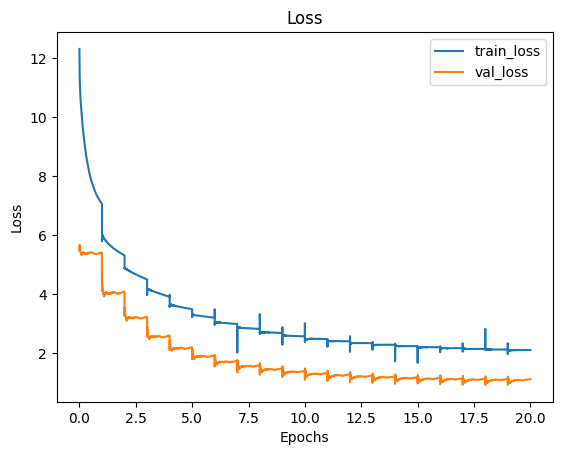

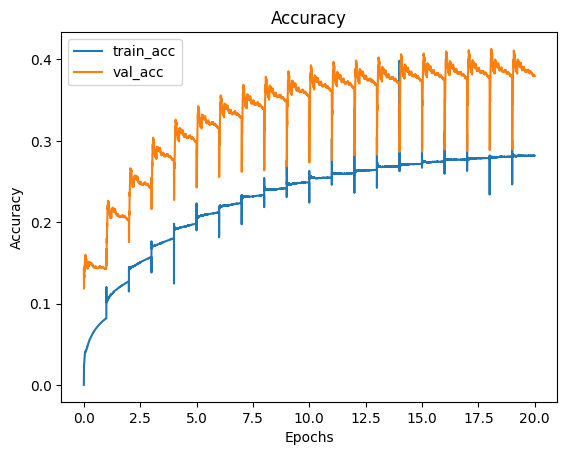

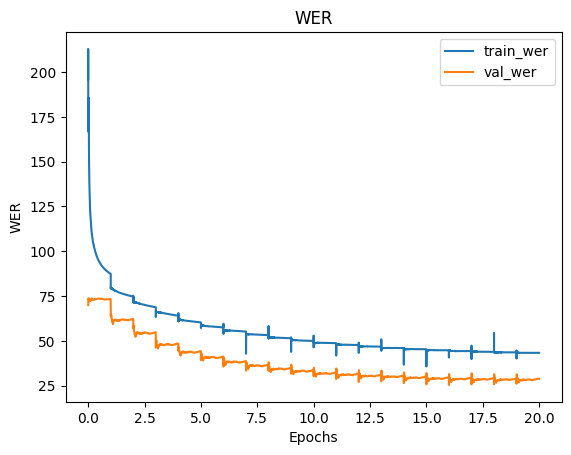

In [118]:
x = []
#print( len( history["train_loss"] ))
for i in range( len( history["train_loss"] )):
    x.append( i / 50000  )
    
v_x = []
#print( len( history["val_loss"]) )
for i in range( len( history["val_loss"]) ):
    v_x.append( i / 250 )

plt.title( "Loss")
plt.xlabel( "Epochs")
plt.ylabel( "Loss")
plt.plot(x, history["train_loss"], label="train_loss")
plt.plot( v_x, history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title( "Accuracy")
plt.xlabel( "Epochs")
plt.ylabel( "Accuracy")
plt.plot(x, history["train_acc"], label="train_acc")
plt.plot( v_x, history["val_acc"], label="val_acc")
plt.legend()
plt.show()

plt.title( "WER")
plt.xlabel( "Epochs")
plt.ylabel( "WER")
plt.plot(x, history["train_wer"], label="train_wer")
plt.plot( v_x, history["val_wer"], label="val_wer")
plt.legend()
plt.show()

In [119]:
#null_index =  j_v.get_stoi()['<pad>']
#max_length = 20

j_t = Tokenizer()
def j_tokenizer(text): 
    return [tok for tok in j_t.tokenize(text, wakati=True)]

@torch.no_grad()
def inference(features: torch.Tensor,
           max_length: int=30):

    bs = features.size(0)
    
    seq_len_src = features.shape[1]

    padding_mask_src = (features == idx_list['<pad>'])

    enc_out = model.encoder( features, None, padding_mask_src )
    
    # <start> トークンで出力キャプションを初期化
    captions = features.new_full(
        (bs, 1), idx_list_en['<bos>'], dtype=torch.int64)

    mask_tgt = nn.Transformer.generate_square_subsequent_mask( captions.size(1) ).to(device)    
    padding_mask_tgt = (captions == idx_list_en['<pad>']).float() * -1e9 
    
    #print( "enc_out:", enc_out )
    # 単語を逐次予測
    for _ in range(max_length):
        #print( "captions:",captions)
        #preds = model.decoder(enc_out, captions, causal_mask = None, dec_padding_mask = dec_padding_mask  )
        preds = model.decoder(enc_out, captions, padding_mask_src, None, mask_tgt )    
        #preds = model.decoder(enc_out, captions, causal_mask = None, dec_padding_mask = None  )
        preds = preds[:, -1]
        preds = preds.argmax(dim=1)
        #print("preds:",preds)
        words = torch.unsqueeze( preds, dim = 1 )
        
        captions = torch.cat((captions, words), dim=1)

    return captions

In [120]:
j_t = Tokenizer()
def j_tokenizer(text): 
    return [tok for tok in j_t.tokenize(text, wakati=True)]

import torch.utils.data as tud

# 推論モジュール
@torch.no_grad()
def beam_search(input_sequence):
    ''' ネットワーク計算(forward処理)の関数
    input_sequence: 各発話の入力系列 [B x Tin x D]
    input_lengths:  各発話の系列長(フレーム数) [B]
        []の中はテンソルのサイズ
        B:    ミニバッチ内の発話数(ミニバッチサイズ)
        Tin:  入力テンソルの系列長(ゼロ埋め部分含む)
        D:    入力次元数(dim_in)
        Tout: 正解ラベル系列の系列長(ゼロ埋め部分含む)
    '''
    predictions = 20
    beam_width = 5
    batch_size = input_sequence.size(0)
        
    enc_mask = input_sequence.eq(idx_list['<pad>']).to(device)
    dec_mask = enc_mask
        
    # エンコーダに入力する
    enc_out = model.encoder(input_sequence, None, enc_mask)
        
    #enc_lengths = input_lengths
        
    X = torch.ones( (enc_out.size(0), 1 ), dtype=torch.int64  ) * idx_list_en['<bos>']

    dec_target_mask = X.eq(idx_list_en['<pad>']).to(device)
    n_ctx = X.size(1)
    causal_mask = torch.empty(n_ctx, n_ctx).fill_(1).triu_(1).to(device).bool()

    #dec_out= model.decoder( enc_out, X, dec_mask, dec_target_mask, causal_mask )
    #preds = model.decoder(enc_out, captions, padding_mask_src, None, mask_tgt )   
    #logits = self.classifier( dec_out )
    logits= model.decoder( enc_out, X, dec_mask, dec_target_mask, causal_mask )
    next_probabilities = logits[:, -1, :]
    vocabulary_size = next_probabilities.shape[-1]
    probabilities, idx = next_probabilities.squeeze().log_softmax(-1)\
        .topk(k = beam_width, axis = -1)
    X = X.repeat((beam_width, 1, 1)).transpose(0, 1)\
        .flatten(end_dim = -2)
    next_chars = idx.reshape(-1, 1)
    X = torch.cat((X, next_chars), axis = -1)
    # This has to be minus one because we already produced a round
    # of predictions before the for loop.
    predictions_iterator = range(predictions - 1)

    for i in predictions_iterator:
        dataset = tud.TensorDataset(X)
        loader = tud.DataLoader(dataset, batch_size = batch_size)
        next_probabilities = []
        iterator = iter(loader)
        for (x,) in iterator:
            dec_target_mask = x.eq(idx_list_en['<pad>']).to(device)
            n_ctx = x.size(1)
            causal_mask = torch.empty(n_ctx, n_ctx).fill_(1).triu_(1).to(device).bool()
            #dec_out= model.decoder( enc_out, x, dec_mask, dec_target_mask, causal_mask )
            #logits = self.classifier( dec_out )
            logits= model.decoder( enc_out, x, dec_mask, dec_target_mask, causal_mask )
            next_probabilities0 = logits[:, -1, :].log_softmax(-1)
            next_probabilities.append(
                next_probabilities0
            )
        next_probabilities = torch.cat(next_probabilities, axis = 0)
        next_probabilities = next_probabilities.reshape(
            (-1, beam_width, next_probabilities.shape[-1])
        )
        probabilities = probabilities.unsqueeze(-1) + next_probabilities
        probabilities = probabilities.flatten(start_dim = 1)
        probabilities, idx = probabilities.topk(
            k = beam_width, 
            axis = -1
        )
        next_chars = torch.remainder(idx, vocabulary_size).flatten()\
            .unsqueeze(-1)
        best_candidates = (idx / vocabulary_size).long()
        best_candidates += torch.arange(
            X.shape[0] // beam_width, 
            device = X.device
        ).unsqueeze(-1) * beam_width
        X = X[best_candidates].flatten(end_dim = -2)
        X = torch.cat((X, next_chars), axis = 1)
        
        #print( "size of X:{}", X.size() )
        
    output = X.reshape( input_sequence.size(0), beam_width, -1 )
    return output[:,0,:]
    #return output


In [121]:
'''
test_text = "現在、筋ジストロフィー患者の移動介助において文書マニュアルを使用している。"
#test_text = "わたしは生きている"

test_text = j_tokenizer( test_text )

test_ids = [ idx_list[s] for s in test_text ]
test_ids.insert( 0, idx_list['<bos>'] )
test_ids.append( idx_list['<eos>'])
'''
test_ids = [1, 6219, 64, 108, 8575, 9, 995, 628, 12749, 29, 5940, 133, 300, 42, 224, 46, 19, 2]

test_ids = torch.tensor( test_ids ).to( device )

sentence = [ token_list[str(i.item())] for i in test_ids ]

print( "sentence:", " ".join( sentence ))

# 正解の文字列を取得
caption = [1, 44, 4489, 6972, 1002, 32, 1513, 153, 15988, 11576, 13, 2]
reference = []
for m in caption:
    reference.append( token_list_en[str(m)])
    if m == idx_list_en['<eos>']:
        break    

print( "reference :", " ".join(reference))        

refs = [ reference ]

test_ids = test_ids.unsqueeze( 0 )

#print( "test_ids:",test_ids )

#preds = inference( test_ids )
preds = beam_search( test_ids )
#print( "size of preds:", preds.size() )
#print( "preds:", preds )

pred = torch.squeeze( preds, dim = 0 )

#print( pred )

sent = []
for m in pred:
    #print( m )
    sent.append( token_list_en[str(m.item())])
    if token_list_en[str(m.item())] == '<eos>':
        break
    
print( 'hypotheses:', ' '.join(sent) )

# 認識誤りを計算
(error, substitute, 
    delete, insert, ref_length) = \
    levenshtein.calculate_error(reference, sent)

fn = bleu_score.SmoothingFunction().method0
#bleu = bleu_score.sentence_bleu( refs, sent, smoothing_function=fn)
bleu = bleu_score.sentence_bleu( refs, sent)
#bleu = bleu_score1( refs, sent )
#print( bleu )
#bleu = bleu_score.sentence_bleu( reference, sent)


print( "WER:", error / len( sent )  * 100, "BLEU:", bleu * 100 )

sentence: <bos> 完成 し た 石鹸 は 通気 性 包装 に 保管 する 必要 が あり ます 。 <eos>
reference : <bos> the finished soap must be stored in breathable packaging . <eos>
hypotheses: <bos> the finished soap must be stored in a breathable packaging . <eos>
WER: 7.6923076923076925 BLEU: 76.11606003349893


In [16]:
import nltk
from nltk import bleu_score

fn = bleu_score.SmoothingFunction().method7
#reference = ['<bos>', 'the', 'finished', 'soap', 'must', 'be', 'stored', 'in', 'breathable', 'packaging', '.', '<eos>']
#sent      = ['<bos>', 'the', 'finished', 'soap', 'must', 'be', 'stored', 'in', 'breathable', 'packaging', '.', '<eos>']

#snet = ['The', 'structure', 'of', 'the', 'is', 'a', 'fault', 'in', 'the', 'machine', '.' ]

#reference = ['There', 'is', 'a', 'fault', 'in', 'the', 'machine', "'s", 'construction', '.' ]

#snet = ['A', 'NASA', 'rover', 'is', 'fighting', 'a', 'massive', 'storm', 'on', 'Mars', '.' ]

#sent = ['The', 'Opportunity', 'rover', 'is', 'combating', 'a', 'big', 'sandstorm', 'on', 'Mars', '.']
sent = ['<bos>', 'the', 'finished', 'soap', 'must', 'be', 'stored', 'in', 'the', 'packaging', '.', '<eos>']

#reference = ['The', 'NASA', 'Opportunity', 'rover', 'is', 'battling', 'a', 'massive', 'dust', 'storm', 'on', 'Mars', '.']
reference = ['<bos>', 'the', 'finished', 'soap', 'must', 'be', 'stored', 'in', 'breathable', 'packaging', '.', '<eos>']
references = [reference]

#reference[1] = ['The', 'NASA', 'Opportunity', 'rover', 'is', 'battling', 'a', 'massive', 'dust', 'storm', 'on', 'Mars', '.']

#bleu = bleu_score.sentence_bleu( references, sent,  smoothing_function=fn)
bleu = bleu_score.sentence_bleu( references, sent)
#bleu = bleu_score.sentence_bleu( sent,reference)
#bleu = bleu_score1( sent,reference )
print( bleu * 100 )

# 認識誤りを計算
(error, substitute, 
    delete, insert, ref_length) = \
    levenshtein.calculate_error(reference, sent)

print( error / len( sent ) * 100 )

print( reference )
print( sent )

73.48889200874657
8.333333333333332
['<bos>', 'the', 'finished', 'soap', 'must', 'be', 'stored', 'in', 'breathable', 'packaging', '.', '<eos>']
['<bos>', 'the', 'finished', 'soap', 'must', 'be', 'stored', 'in', 'the', 'packaging', '.', '<eos>']


In [104]:
test_dataset = SequenceDataset( "20240531_ntt_ids_test_auto.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>'] )

test_loader = DataLoader(test_dataset,
                        batch_size=1,
                        shuffle=False,
                        num_workers=0)

n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 3630
n: 3631
n: 3632
n: 3633
n: 3634
n: 3635
n: 3636
n: 3637
n: 3638
n: 3639
n: 3640
n: 3641
n: 3642
n: 3643
n: 3644
n: 3645
n: 3646
n: 3647
n: 3648
n: 3649
n: 3650
n: 3651
n: 3652
n: 3653
n: 3654
n: 3655
n: 3656
n: 3657
n: 3658
n: 3659
n: 3660
n: 3661
n: 3662
n: 3663
n: 3664
n: 3665
n: 3666
n: 3667
n: 3668
n: 3669
n: 3670
n: 3671
n: 3672
n: 3673
n: 3674
n: 3675
n: 3676
n: 3677
n: 3678
n: 3679
n: 3680
n: 3681
n: 3682
n: 3683
n: 3684
n: 3685
n: 3686
n: 3687
n: 3688
n: 3689
n: 3690
n: 3691
n: 3692
n: 3693
n: 3694
n: 3695
n: 3696
n: 3697
n: 3698
n: 3699
n: 3700
n: 3701
n: 3702
n: 3703
n: 3704
n: 3705
n: 3706
n: 3707
n: 3708
n: 3709
n: 3710
n: 3711
n: 3712
n: 3713
n: 3714
n: 3715
n: 3716
n: 3717
n: 3718
n: 3719
n: 3720
n: 3721
n: 3722
n: 3723
n: 3724
n: 3725
n: 3726
n: 3727
n: 3728
n: 3729
n: 3730
n: 3731
n: 3732
n: 3733
n: 3734
n: 3735
n: 3736
n: 3737
n: 3738
n: 3739
n: 3740
n: 3741
n: 3742
n: 3743
n: 3744
n: 3745
n: 3746
n: 3747
n: 3748
n: 3749
n: 3750
n: 3751
n: 3752
n: 3753
n: 3754


In [123]:
import nltk
from nltk import bleu_score

model.eval()
print("Test")
total_error = 0
total_token_length = 0
test_loss = 0
total_bleu = 0
n = 0
n1 = 0
for i, (text, label, text_len, target_len) in enumerate(test_loader):
    if i > 50:
    #if i > 5:
        break
    text, label, text_len, target_len = text.to(device), label.to(device), text_len.to(device), target_len.to(device)
    text = text[:,:max(text_len)]
    label = label[:,:max(target_len)]
    
    with torch.no_grad():
        preds = inference( text )
        #preds = beam_search( text )

        #preds = torch.argmax( outputs, dim = 2 )
        #print( "preds:", preds)
        #acc = torch.mean( (preds == target.float()).float() )
        #total_acc += acc.item()

    n2 = 0
    jap_sentence = []
    hypo_sentence = []
    ref_sentence = []
    for hypo_id, caption, japa in zip( preds, label, text ):
        jap = []
        for m in japa:
            jap.append( token_list[str(m.item())])
            if m == idx_list['<eos>']:
                break
        hypo = []
        for m in hypo_id:
            hypo.append(token_list_en[str(m.item())])
            if m == idx_list_en['<eos>']:
                break
        # 正解の文字列を取得
        reference = []
        for m in caption:
            reference.append( token_list_en[str(m.item())])
            if m == idx_list_en['<eos>']:
                break
                        
        # 認識誤りを計算
        (error, substitute, 
            delete, insert, ref_length) = \
            levenshtein.calculate_error(hypo,reference)
        refs = [ reference ]
        #bleu = bleu_score.sentence_bleu( refs, hypo, smoothing_function=fn)
        bleu = bleu_score.sentence_bleu( refs, hypo)
        
        #print( "bleu:", bleu )
            
        total_error += error
        total_token_length += ref_length
        total_bleu += bleu

        #if n2 < 4 and i == len( val_loader ) -1 :
        jap_sentence.append( ''.join(jap))
        hypo_sentence.append( ' '.join(hypo) )
        ref_sentence.append( ' '.join(reference ) )
                    
        n2 += 1
        n1 += 1
        
    #val_loss += loss.item()
    n += 1
    print(f"index:{i+1}  WER:{total_error / total_token_length * 100:.10f}, BLEU:{ total_bleu / n1 * 100 }")
    #if i == len( test_loader ) - 1:
    for i, (hypo_s, refe_s, jap_s ) in enumerate( zip( hypo_sentence, ref_sentence, jap_sentence ) ):
        if i > 4:
            break
        print( "japa:", jap_s)
        print( "refe:", refe_s)
        print( "hypo:", hypo_s )

Test
index:1  WER:16.6666666667, BLEU:64.93358309501978
japa: <bos>完成した石鹸は通気性包装に保管する必要があります。<eos>
refe: <bos> the finished soap must be stored in breathable packaging . <eos>
hypo: <bos> finished soap must be stored in a breathable packaging . <eos>
index:2  WER:30.7692307692, BLEU:45.2586432406073
japa: <bos>そのような困難な仕事を占めた最初の会社はバッファローでした。<eos>
refe: <bos> the first company that occupied such a difficult task was buffalo . <eos>
hypo: <bos> the first company who occupied such difficulties was a buffer . <eos>
index:3  WER:36.8421052632, BLEU:38.57640755518814
japa: <bos>最初の評議会は6月末にハッチングします。<eos>
refe: <bos> the first council hatches at the end of june . <eos>
hypo: <bos> the first council will be set to six months . <eos>
index:4  WER:32.6530612245, BLEU:44.32302311536739
japa: <bos>最初に炭水化物、タンパク質、脂肪を含む。<eos>
refe: <bos> the first includes carbohydrates , proteins , fats . <eos>
hypo: <bos> first include carbohydrates , proteins , fats . <eos>
index:5  WER:32.2033898305, BLEU:44.6931511

index:32  WER:24.1237113402, BLEU:53.06893565258033
japa: <bos>フレームが内側にノックアウトされており、釘は外側に曲がっています。<eos>
refe: <bos> the frame is knocked out inside , and nails are bent outside . <eos>
hypo: <bos> the frame is knocked inside , and the nails are bent outside . <eos>
index:33  WER:24.2000000000, BLEU:52.78192715241925
japa: <bos>フレームワークはボードや木の杭の冬に設置されています。<eos>
refe: <bos> the framework is installed for the winter of boards or wooden piles . <eos>
hypo: <bos> the framework is installed in winter on boards and wooden piles . <eos>
index:34  WER:29.0613718412, BLEU:51.79564663673477
japa: <bos>無料版にはカレンダーモジュールを搭載したモダンなスキャナが含まれています。 これにより、疑わしいファイルを監視するための検疫モジュール、検証レポートのログ、および約500,000の署名を含む巨大なベースの検疫モジュールがあります。<eos>
refe: <bos> the free version includes a modern scanner with a calendar module , which gives you the opportunity to plan the system checks in advance , a quarantine module for monitoring suspicious files , a log of verification reports and a huge base of viruses that contains about 50